### Homework 4: Kalman Filter

##### Hasan Cetin

<hr \>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import numba as nb

from numba import njit

Let's first define our AR(1), AR(2), and MA(1) processes (Random walk is a special case of AR(1)):

In [2]:
@njit
def ar_1(x_0=0, ρ=0.6, Q = 1, size=100):
    x = np.empty(shape=(size,1))
    x[0] = x_0
    for i in range(size - 1):
        x[i+1] = ρ * x[i] + np.random.normal(loc = 0, scale=Q)
    return x

@njit
def ar_2(x_0=0, ρ1=0.5, ρ2=0.2, Q=1,  size=100):
    x = np.empty(shape=(size,1))
    x[0] = x_0
    x[1] = ρ1 * x[0] + np.random.normal(loc = 0, scale=Q)
    for i in range(size-2):
        x[i+2] = ρ1 * x[i+1] + ρ2*x[i] + np.random.normal(loc = 0, scale=Q)
    return x

@njit
def ma_1(x_0=0, ρ=0.8, size=100, Q = 1):
    x = np.empty(shape=(size,1))
    shocks = np.random.normal(size = size, scale=Q)
    x[0] = x_0
    for i in range(size-1):
        x[i+1] = shocks[i+1] + ρ * shocks[i]
    return x

@njit
def random_walk(x_0=0, H = 1, Q = 1, size=100):
    μ = np.empty(shape=(size,1))
    x = np.empty(shape=(size,1))
    x[0] = x_0
    μ[0] = x_0
    for i in range(size - 1):
        μ[i+1] =  μ[i] + np.random.normal(loc = 0, scale=Q)
        x[i+1] = μ[i+1] + np.random.normal(loc = 0, scale=H)
    return x

<hr />

## General Theory

Let's assume the law of motions of the unobservable and observable RV's are the following Time series:

$$\text{Unobservable: } \alpha_t = T \alpha_{t-1} + \eta_t, \text{where, } \eta_{t+1} \sim N(0,Q)$$
$$\text{Observable: } y_t = Z\alpha_t + ϵ_t, \text{where, } \epsilon_t \sim N(0,H)$$

Assume the shocks for both series are serially uncorrelated.

For computation purposes let's write down the dimensions of each variable. (for each observation t)

Assume there are **n** observable random variable and **m** unobservable random variable for each time t. Then the dimensions are:

- T: (m,m)
- Z: (n,m)
- H: (n,n)
- Q: (m,m)
- $\alpha_t$: (m,1)
- $\eta_t$: (m,1)
- $\epsilon_t$: (n,1)

Our goal is to estimate parameters (T, Q, Z and H) by using the observable sequence.

To do that we'll connect our system:

$$\hat \alpha_{t+1|t} = T \hat α_{t|t-1} + K_t v_t$$
$$y_t = Z \hat α_{t|t-1} + v_t$$

Here:

- $\hat \alpha_{t+1|t}:$ Estimate of the unobserved state vector,
- $v_t:$ Innovation (Difference between the observable and the forecast)
- $K_t:$ Kalmar gain

Our goal is to find parameters such that the error is small enough. Then, we can conclude that those parametes will be most "likely" to have generated the sequence of observables that we observed.

How do we get $v_t$? To get it, we need to solve a sequence of recursions:

Suppose at time t, we have:

1) **estimate**: $\hat \alpha_{t-1} = \mathbb{E}[\alpha_{t-1}|y_0,y_1,\dots y_{t-1}]$
2) **estimation error for $\alpha_{t-1}$**: $P_{t-1} = \mathbb{E}[(α_{t-1} - \hat \alpha_{t-1})(α_{t-1} - \hat \alpha_{t-1})']$

Then, given $\hat \alpha_{t-1}, P_{t-1}$, we can estimate $\alpha_t$ by using **one step prediction mean and variances** as:
\begin{equation}
\tag{1}
 \text{(Prediciton mean):}\;\; \hat α_{t|t-1} = T \hat α
\end{equation}

$$\hat P_{t|t-1} = \mathbb{E}[(\alpha_t - \hat \alpha_{t|t-1})(\alpha_t - \hat \alpha_{t|t-1})']$$
$$\mathbb{E}[(T\alpha_{t-1} + \eta_t - T\hat \alpha_{t-1})(T\alpha_{t-1} + \eta_t - T\hat \alpha_{t-1})']$$

\begin{equation}
\tag{2}
\text{(Prediciton variance):}\;\; \hat P_{t|t-1} = T P_{t-1} T' + Q
\end{equation}

Next, we update our estimate after the observation $y_t$: from $\mathbb{E}[\alpha_t|y_0,y_1,y_2 … y_{t-1}]$ to $\mathbb{E}[\alpha_t|y_0,y_1,y_2 … y_{t}]$

So far, without knowing the $y_t$, the best estimate for $y_t$ is:

$$\hat y_{t|t-1} = Z \hat \alpha_{t|t-1}$$

Then, define the innovation (measurement error of the observable):

\begin{equation}
\tag{3}
v_t = y_t - \hat y_{t|t-1} = Z (\alpha_t - \hat \alpha_{t|t-1}) + ϵ_t
\end{equation}

And define the variance of this innovation as:

$$Var(v_t) = F_t = \mathbb{E}[v_t v_t']$$
$$\mathbb{E}[(Z (\alpha_t - \hat \alpha_{t|t-1}) + ϵ_t)(Z (\alpha_t - \hat \alpha_{t|t-1}) + ϵ_t)']$$

\begin{equation}
\tag{4}
F_t = ZTP_{t-1}T'Z' +ZQZ' + H
\end{equation}

Then, the covariance of innovation $v_t = (y_t - \hat y_{t|t-1})$ (which is the measurement error of the observable) and the estimation error $(\alpha_t - \hat \alpha_{t|t-1})$ is:

$$G_t = \mathbb{E}[v_t (\alpha_t - \hat \alpha_{t|t-1})']$$
$$= \mathbb{E}[(y_t - \hat y_{t|t-1}) (\alpha_t - \hat \alpha_{t|t-1})']$$
$$= \mathbb{E}[(Z(\alpha_t - \hat \alpha_{t|t-1})+ \epsilon_t)) (\alpha_t - \hat \alpha_{t|t-1})']$$

\begin{equation}
\tag{5}
G_t = Z P_{t|t-1}
\end{equation}

Then, the conditional mean and variance are: (Using Gaussian RV properties)


\begin{equation}
\tag{6}
\hat \alpha_t = \hat \alpha_{t|t-1} + P_{t|t-1}Z'(ZP_{t|t-1}Z' + H)^{-1}(y_t - Zα_{t|t-1})
\end{equation}


\begin{equation}
\tag{7}
P_t = P_{t|t-1} - P_{t|t-1}Z'(ZP_{t|t-1}Z' + H)^{-1}ZP_{t|t-1}
\end{equation}

The idea here is that, the new information $y_t$ is used to estimate new prediction density with mean $\hat \alpha_t$ and variance $P_t$.

Then, we will find our new estimate for $\alpha_{t+1}$ by multiplying both sides of conditional mean with $T$:

\begin{equation}
\tag{8}
 \hat \alpha_{t+1|t}= T\hat \alpha_t = T\hat \alpha_{t|t-1} + TP_{t|t-1}Z'(ZP_{t|t-1}Z' + H)^{-1}(y_t - Zα_{t|t-1})
\end{equation}

and so on...


So the Kalman algorithm is the following:
- For all parameter Q,Z,T,H candidates, do the following:

    - Start with initial guess of $\alpha_0$ and $P_0$
    - Recursively update your $\hat α_t's$ and $P_t's$ for each observation
    - While you are updating your estimates, store $v_t$ and correspondingly, $F_t$
    - To estimate the parameters T,Q,H and Z, do Kalman filtering for a 4 dimensional grid of estimate nominees. After each filtering, Use their $v_t$ and $F_t's$ to compute the log-likelihood of the estimation: $log(L) = \sum_{t} (-\frac{n}{2}log(2 \pi) - \frac{1}{2} log(|F_t|) - \frac{1}{2}v_t'F_t^{-1}v_t)$

- Pick the parameters that maximizes this log-likelihood estimate. Voila.


In [3]:
class KalmanEstimation:
    def __init__(self, Z=None, Ti=None, Q=None, H=None, P_0 = None, α_0 = 0, obs=None):
        
        if(Ti is None or Z is None):
            raise ValueError("Set proper system dynamics.")
       
        self.n = Z.shape[0]
        self.m = Z.shape[1]

        self.Z = Z                                                #Z parameter of the observable equation
        self.Ti = Ti                                              #T parameter of the unobservable equation
        self.Q = np.eye(self.m) if Q is None else Q               #Variance estimation of \eta_t
        self.H = np.eye(self.n) if H is None else H               #Variance estimation of \epsilon_t
        self.P_0 = 0.1 * np.eye(self.m) if P_0 is None else P_0   #Initial guess for the estimate variance
        self.α_0 = α_0                                            #Initial guess for the estimate mean
        self.obs = obs                                            #Observations
        self.obs_size = obs.shape[0]                              #Observation size

        self.α_t = np.empty(shape=(self.obs_size + 1,1))          #\hat \alpha_{t}
        self.α_t[0] = self.α_0

        self.P_t = []                                             #P_t
        self.P_t.append(self.P_0)                                      

        self.v_t = np.empty(shape=self.obs_size)                  #v_t
        self.F_t = np.empty(shape=self.obs.size)                  #F_t

    def recursion(self):
        for i in range(self.obs_size):
            α_t_t_1 =  np.dot(self.Ti, self.α_t[i])               #1st equation in the general theory section: estimate for \alpha_t without seeing y_t

            P_t_t_1 = np.dot(np.dot(self.Ti, self.P_t[i]),self.Ti.T) + self.Q  #2nd equation in the general theory section: estimate variance P_{t|t-1} 

            self.α_t[i+1] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**(-1)),(self.obs[i]-np.dot(self.Z,α_t_t_1)))   #6th equation in the general theory section:  updating conditional mean

            self.P_t.append(P_t_t_1 - np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**(-1)), np.dot(self.Z,P_t_t_1))) #7th equation in the general theory section: updating conditional variance

            estimate_for_obs = np.dot(self.Z,α_t_t_1)

            self.v_t[i] = self.obs[i] - estimate_for_obs      #v_t: 3th equation in the general theory section: storing innovation to calculate log-likelihood
            self.F_t[i] = np.dot(np.dot(np.dot(np.dot(self.Z,self.Ti),self.P_t[i]),self.Ti.T),self.Z.T) + np.dot(np.dot(self.Z, self.Q),self.Z.T) + self.H # F_t: 7th equation in the general theory section: storing innovation variance to calculate log-likelihood

        self.log_likelihood = np.sum(- self.obs_size/2 * np.log(2*np.pi) - 1/2 * np.log(np.abs(self.F_t)) - 1/2 * self.v_t.T * (self.F_t**(-1)) * self.v_t) # Calculating log likelihood

<hr />

## AR(1) Process

Our state space:

$$\alpha_t = T \alpha_{t-1} + \eta_t \;\; \text{where, } \eta_{t} \sim N(0,Q)$$
$$y_t = \alpha_t$$

Thus, we have:

- 1 random variable for unobservable and observable: m = n = 1
- Z = 1
- H = 0
- Q and T are (1,1) scalar which are unknown.

In our maximization, since we know what Z and H are, we only search in (T,Q) grid to find the real variables.

Assume that in the real data, T = 0.5, Q = 1.2.

Our grid for both parameters will be from 0 to 2.

Let's estimate it:

In [4]:
Observations = ar_1(x_0 = 0, ρ=0.5, Q=1.2, size = 100)   #Our y_t = \alpha_t

T = np.linspace(0,2,25) #Candidate T values
Q = np.linspace(0,2,25) #Candidate Q values

i = 0
j = 0
value = -np.inf
for t in T:
    for q in Q:
        Model = KalmanEstimation(Z=np.array([[1]]), Ti= t , Q=q, H=np.array([[0]]), P_0=np.array([[0.1]]), α_0=1, obs=Observations)
        Model.recursion()
        Value = Model.log_likelihood
        if Value > value:
            value = Value
            i = t
            j = q
            



/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_75555/1285615880.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  self.α_t[i+1] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**(-1)),(self.obs[i]-np.dot(self.Z,α_t_t_1)))   #6th equation in the general theory section:  updating conditional mean
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_75555/1285615880.py:34: RuntimeWarning: invalid value encountered in reciprocal
  self.α_t[i+1] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**(-1)),(self.obs[i]-np.dot(self.Z,α_t_t_1)))   #6th equation in the general theory section:  updating conditional mean
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_75555/1285615880.py:36: RuntimeWarning: divide by zero encountered in reciprocal
  self.P_t.append(P_t_t_1 - np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T)

In [5]:
print('After Kalman Filtering, Our parameter approximations are:')

print('T: ', i)
print('Q: ', j) 

After Kalman Filtering, Our parameter approximations are:
T:  0.5833333333333333
Q:  1.5


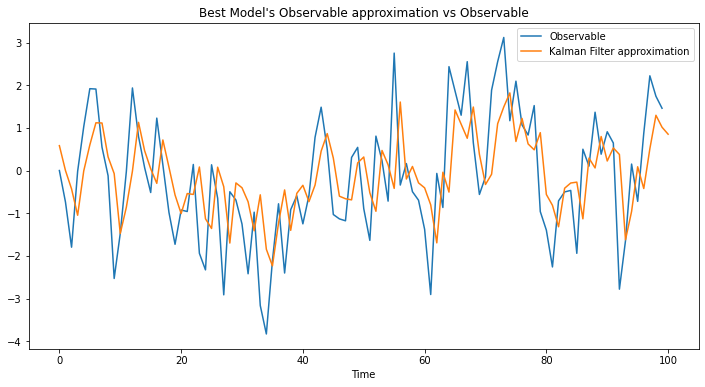

In [6]:
fig, ax = plt.subplots(figsize = (12,6))

Best_Model = KalmanEstimation(Z=np.array([[1]]), Ti= np.array([[i]]) , Q=np.array([[j]]), H=np.array([[0]]), P_0=np.array([[0.1]]), α_0=1, obs=Observations)

ax.plot(Best_Model.obs, label= 'Observable')
ax.plot(Best_Model.Ti * Model.α_t, label = 'Kalman Filter approximation')
ax.set_xlabel('Time')
ax.legend()
ax.set_title("Best Model's Observable approximation vs Observable")

plt.show()

As you can see, Kalman filter did a good job.

<hr />

## Random Walk Process

$$x_{t+1} =  \mu_{t+1} + ϵ_{t+1}, \;\; \text{where, } ϵ_{t+1} \sim N(0,Q)$$
$$\text{s.t. } \mu_{t+1} = \mu_t + \eta_{t+1}$$

Our state space:

$$\alpha_t = \alpha_{t-1} + \eta_t$$
$$y_t = \alpha_t + \epsilon_t$$

Thus, we have:

- 1 random variable for unobservable and observable: m = n = 1
- Z,T = 1  (Random walk is a special case of AR(1) process.)
- Q and H are (1,1) scalar which are unknown.

To simulate, assume H = 1.3, Q = 1.1 

In [16]:
Observations = random_walk(x_0 = 0, H=1.3, Q=1.1, size = 100)   #Our y_t = \alpha_t

H = np.linspace(0,5,50)
Q = np.linspace(0,2,25)

i = 0
j = 0
value = -np.inf
for h in H:
    for q in Q:
        Model = KalmanEstimation(Z=np.array([[1]]), Ti= np.array([[1]]) , Q=q, H=np.array([[h]]), P_0=np.array([[0.1]]), α_0=1, obs=Observations)
        Model.recursion()
        Value = Model.log_likelihood
        if Value > value:
            value = Value
            i = t
            j = q
            

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_67008/2124810866.py:34: RuntimeWarning: invalid value encountered in reciprocal
  self.α_t[i+1] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**(-1)),(self.obs[i]-np.dot(self.Z,α_t_t_1)))   #6th equation in the general theory section:  updating conditional mean
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_67008/2124810866.py:36: RuntimeWarning: invalid value encountered in reciprocal
  self.P_t.append(P_t_t_1 - np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**(-1)), np.dot(self.Z,P_t_t_1))) #7th equation in the general theory section: updating conditional variance
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_67008/2124810866.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  self.α_t[i+1] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**

In [17]:
print('After Kalman Filtering, Our parameter approximations are:')

print('H: ', i)
print('Q: ', j) 

After Kalman Filtering, Our parameter approximations are:
H:  2.0
Q:  0.5


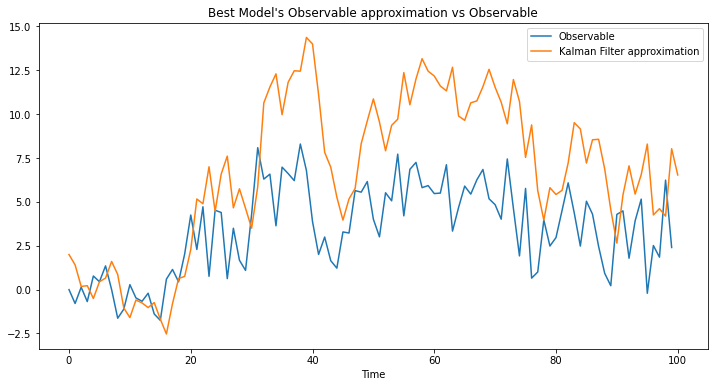

In [18]:
fig, ax = plt.subplots(figsize = (12,6))

Best_Model = KalmanEstimation(Z=np.array([[1]]), Ti= np.array([[i]]) , Q=np.array([[j]]), H=np.array([[0]]), P_0=np.array([[0.1]]), α_0=1, obs=Observations)

ax.plot(Best_Model.obs, label= 'Observable')
ax.plot(Best_Model.Ti * Model.α_t, label = 'Kalman Filter approximation')
ax.set_xlabel('Time')
ax.legend()
ax.set_title("Best Model's Observable approximation vs Observable")

plt.show()

<hr />

## AR(2) Process

$$x_{t+1} = \rho_1 x_t + \rho_2 x_{t_1} + ϵ_{t+1}\,;\; \text{where, } ϵ_{t+1} \sim N(0,Q)$$

The unobservable is: $\alpha_t = \begin{bmatrix} x_{t-1} \\ x_{t-2} \end{bmatrix}$

Then the state space is:

$$\begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix}  = \underbrace{\begin{bmatrix} ρ_1 & ρ_2 \\ 1 & 0 \end{bmatrix}}_{T} \begin{bmatrix} x_{t-1} \\ x_{t-2}\end{bmatrix} + \begin{bmatrix} ϵ_t \\ 0 \end{bmatrix}$$

$$x_t = \underbrace{\begin{bmatrix} 1 & 0 \end{bmatrix}}_{Z} \begin{bmatrix} x_t \\ x_{t-1}\end{bmatrix}$$

Thus H = 0, and in T and Q we need to estimate $ρ_1, \rho_2, ϵ_t$ only.

In [70]:
class KalmanEstimation2d:
    def __init__(self, Z=None, Ti=None, Q=None, H=None, P_0 = None, α_0 = 0, obs=None):
        
        if(Ti is None or Z is None):
            raise ValueError("Set proper system dynamics.")
       
        self.n = Z.shape[0]
        self.m = Z.shape[1]

        self.Z = Z                                                #Z parameter of the observable equation
        self.Ti = Ti                                              #T parameter of the unobservable equation
        self.Q = np.eye(self.m) if Q is None else Q               #Variance estimation of \eta_t
        self.H = np.eye(self.n) if H is None else H               #Variance estimation of \epsilon_t
        self.P_0 = 0.1 * np.eye(self.m) if P_0 is None else P_0   #Initial guess for the estimate variance
        self.α_0 = α_0                                            #Initial guess for the estimate mean
        self.obs = obs                                            #Observations
        self.obs_size = obs.shape[0]                              #Observation size

        self.α_t = np.empty(shape=(self.obs_size + 1,2))          #\hat \alpha_{t}
        self.α_t[0,:] = self.α_0

        self.P_t = []                                             #P_t
        self.P_t.append(self.P_0)                                      

        self.v_t = np.empty(shape=self.obs_size)                  #v_t
        self.F_t = np.empty(shape=self.obs.size)                  #F_t

    def recursion(self):
        for i in range(self.obs_size):
            α_t_t_1 =  np.dot(self.Ti, self.α_t[i])               #1st equation in the general theory section: estimate for \alpha_t without seeing y_t

            P_t_t_1 = np.dot(np.dot(self.Ti, self.P_t[i]),self.Ti.T) + self.Q  #2nd equation in the general theory section: estimate variance P_{t|t-1} 

            self.α_t[i+1,:] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T))**(-1)),(self.obs[i]-np.dot(self.Z,α_t_t_1)))   #6th equation in the general theory section:  updating conditional mean

            self.P_t.append(P_t_t_1 - np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T))**(-1)), np.dot(self.Z,P_t_t_1))) #7th equation in the general theory section: updating conditional variance

            estimate_for_obs = np.dot(self.Z,α_t_t_1)

            self.v_t[i] = self.obs[i] - estimate_for_obs      #v_t: 3th equation in the general theory section: storing innovation to calculate log-likelihood
            self.F_t[i] = np.dot(np.dot(np.dot(np.dot(self.Z,self.Ti),np.array(self.P_t[i])),self.Ti.T),self.Z.T) + np.dot(np.dot(self.Z, self.Q),self.Z.T)  # F_t: 7th equation in the general theory section: storing innovation variance to calculate log-likelihood

        self.log_likelihood = np.sum(- self.obs_size/2 * np.log(2*np.pi) - 1/2 * np.log(np.abs(self.F_t)) - 1/2 * self.v_t.T * (self.F_t**(-1)) * self.v_t) # Calculating log likelihood

In [71]:
np.array([1,0]).shape

(2,)

In [86]:
Observations = ar_2(x_0 = 0, ρ1= 0.8, ρ2=0.2, size = 100, Q = 1.2)

T_1 = np.linspace(0,2,25) #for \rho_1
T_2 = np.linspace(0.01,2,25) #for \rho_2 started from non zero to make T invertible
Q = np.linspace(0,2,25) #for epsilon

i = (0,0)
j = 0
value = -np.inf
for t1 in T_1:
    for t2 in T_2:
        for q in Q:
            Model = KalmanEstimation2d(Z=np.array([[1, 0]]), Ti= np.array([[t1,t2],[1,0]]) , Q=np.array([[q, 0], [0,q]]), H=np.array([[0,0], [0,0]]), P_0=np.array([[0.2, 0.1], [0.1,0.2]]), α_0=1, obs=Observations)
            Model.recursion()
            Value = Model.log_likelihood
            if Value > value:
                value = Value
                i = (t1,t2)
                j = q
                alphas = Model.α_t

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_75555/1185047037.py:34: RuntimeWarning: invalid value encountered in reciprocal
  self.α_t[i+1,:] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T))**(-1)),(self.obs[i]-np.dot(self.Z,α_t_t_1)))   #6th equation in the general theory section:  updating conditional mean
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_75555/1185047037.py:36: RuntimeWarning: invalid value encountered in reciprocal
  self.P_t.append(P_t_t_1 - np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T))**(-1)), np.dot(self.Z,P_t_t_1))) #7th equation in the general theory section: updating conditional variance
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_75555/1185047037.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  self.α_t[i+1,:] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T))**(-1)),(self.obs[i]-np.d

In [87]:
print('After Kalman Filtering, Our parameter approximations are:')

print('T: ', i)
print('Q: ', j) 

After Kalman Filtering, Our parameter approximations are:
T:  (0.9166666666666666, 0.09291666666666666)
Q:  1.25


In [88]:
alphas

array([[ 1.        ,  1.        ],
       [ 0.        ,  0.86465152],
       [ 0.27319508,  0.        ],
       [ 1.4027755 ,  0.27319508],
       [ 0.32961576,  1.4027755 ],
       [ 1.31479665,  0.32961576],
       [ 0.49560427,  1.31479665],
       [ 1.27217353,  0.49560427],
       [ 2.94187553,  1.27217353],
       [ 3.19433904,  2.94187553],
       [ 2.90290755,  3.19433904],
       [ 4.09437394,  2.90290755],
       [ 4.46821979,  4.09437394],
       [ 5.16079641,  4.46821979],
       [ 2.6518026 ,  5.16079641],
       [ 2.57812992,  2.6518026 ],
       [ 3.25982456,  2.57812992],
       [ 1.70001464,  3.25982456],
       [ 1.43911443,  1.70001464],
       [ 1.91549367,  1.43911443],
       [ 0.92347825,  1.91549367],
       [ 0.48618992,  0.92347825],
       [-1.06888431,  0.48618992],
       [ 0.24832315, -1.06888431],
       [ 0.9139953 ,  0.24832315],
       [ 2.55900761,  0.9139953 ],
       [ 3.03134576,  2.55900761],
       [ 4.32989884,  3.03134576],
       [ 5.96134119,

In [90]:
alphas.shape

(101, 2)

In [95]:
T = np.array([[0.91, 0.092], [1,0]])

estimate = np.zeros((alphas.shape))
for alpha in range(alphas.shape[0]):
    estimate[alpha, :] = np.dot(T, alphas[alpha,:])

estimate

array([[ 1.002     ,  1.        ],
       [ 0.07954794,  0.        ],
       [ 0.24860752,  0.27319508],
       [ 1.30165965,  1.4027755 ],
       [ 0.42900569,  0.32961576],
       [ 1.2267896 ,  1.31479665],
       [ 0.57196118,  0.49560427],
       [ 1.20327351,  1.27217353],
       [ 2.7941467 ,  2.94187553],
       [ 3.17750108,  3.19433904],
       [ 2.93552506,  2.90290755],
       [ 3.99294778,  4.09437394],
       [ 4.44276241,  4.46821979],
       [ 5.10740096,  5.16079641],
       [ 2.88793363,  2.6518026 ],
       [ 2.59006406,  2.57812992],
       [ 3.2036283 ,  3.25982456],
       [ 1.84691718,  1.70001464],
       [ 1.46599548,  1.43911443],
       [ 1.87549776,  1.91549367],
       [ 1.01659063,  0.92347825],
       [ 0.52739283,  0.48618992],
       [-0.92795525, -1.06888431],
       [ 0.12763671,  0.24832315],
       [ 0.85458145,  0.9139953 ],
       [ 2.41278449,  2.55900761],
       [ 2.99395334,  3.03134576],
       [ 4.21909176,  4.32989884],
       [ 5.82317118,

In [96]:
estimate[:, 0]

array([ 1.002     ,  0.07954794,  0.24860752,  1.30165965,  0.42900569,
        1.2267896 ,  0.57196118,  1.20327351,  2.7941467 ,  3.17750108,
        2.93552506,  3.99294778,  4.44276241,  5.10740096,  2.88793363,
        2.59006406,  3.2036283 ,  1.84691718,  1.46599548,  1.87549776,
        1.01659063,  0.52739283, -0.92795525,  0.12763671,  0.85458145,
        2.41278449,  2.99395334,  4.21909176,  5.82317118,  5.0705643 ,
        6.00860707,  7.89687809,  8.4145711 , 10.62937353, 10.83500217,
       12.18968587, 11.56923033, 11.1460403 , 10.90645617,  9.72695344,
        9.16435839,  9.89642498,  8.78579607,  7.93266028,  7.36056321,
        8.75829167,  7.58830753,  8.93744359,  9.0740539 ,  8.80040854,
        8.07293322,  6.49622738,  7.83853422,  8.23876585,  7.52870274,
        4.91931643,  5.23945079,  4.73516382,  3.85545967,  3.39220819,
        3.49355831,  5.22187164,  4.73074242,  4.91070745,  3.45258582,
        4.51630354,  3.93048084,  4.60486265,  2.88986671,  1.83

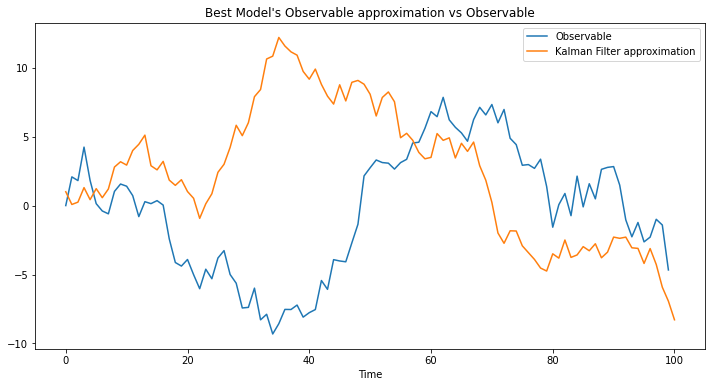

In [99]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(Best_Model.obs, label= 'Observable')
ax.plot(estimate[:,0], label = 'Kalman Filter approximation')
ax.set_xlabel('Time')
ax.legend()
ax.set_title("Best Model's Observable approximation vs Observable")

plt.show()

<hr />

## MA(1) Process

$$x_{t+1} = \rho ϵ_t + ϵ_{t+1}, \;\; \text{where, } ϵ_{t+1} \sim N(0,Q)$$


Our unobservables is this case is :

$$\alpha_t = \begin{bmatrix} epsilon_{t-1} \end{bmatrix}$$

State space:

$$\alpha_t = T \alpha_{t-1} + \epsilon_t, \; \text{where, } \eta_t \sim N(0, Q)$$

$$y_t =\alpha_t, \; \text{where, } Z = \begin{bmatrix} 1 \end{bmatrix}$$


Like in AR(1) process, Z = 1, H = 0, T and Q are the only unknowns and both are scalars.

Let's assume that T = 0.7, Q = 1.2 and simulate the time series.


In [42]:
Observations = ma_1(x_0 = 0, ρ = 0.8, size = 100, Q = 1.2)

T = np.linspace(0,2,25)
Q = np.linspace(0,2,25)

i = 0
j = 0
value = -np.inf
for t in T:
    for q in Q:
        Model = KalmanEstimation(Z=np.array([[1]]), Ti= t , Q=q, H=np.array([[0]]), P_0=np.array([[0.1]]), α_0=1, obs=Observations)
        Model.recursion()
        Value = Model.log_likelihood
        if Value > value:
            value = Value
            i = t
            j = q

C:\Users\hmc98\AppData\Local\Temp\ipykernel_12496\2961427753.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  self.α_t[i+1] = α_t_t_1 + np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**(-1)),(self.obs[i]-np.dot(self.Z,α_t_t_1)))   #6th equation in the general theory section:  updating conditional mean
C:\Users\hmc98\AppData\Local\Temp\ipykernel_12496\2961427753.py:36: RuntimeWarning: divide by zero encountered in reciprocal
  self.P_t.append(P_t_t_1 - np.dot(np.dot(np.dot(P_t_t_1,self.Z.T),(np.dot(np.dot(self.Z,P_t_t_1),self.Z.T) + self.H)**(-1)), np.dot(self.Z,P_t_t_1))) #7th equation in the general theory section: updating conditional variance
C:\Users\hmc98\AppData\Local\Temp\ipykernel_12496\2961427753.py:43: RuntimeWarning: divide by zero encountered in log
  self.log_likelihood = np.sum(- self.obs_size/2 * np.log(2*np.pi) - 1/2 * np.log(np.abs(self.F_t)) - 1/2 * self.v_t.T * (self.F_t**(-1)) * self.v_t) # Calculating log l

In [43]:
print('After Kalman Filtering, Our parameter approximations are:')

print('T: ', i)
print('Q: ', j) 

After Kalman Filtering, Our parameter approximations are:
T:  0.41666666666666663
Q:  2.0


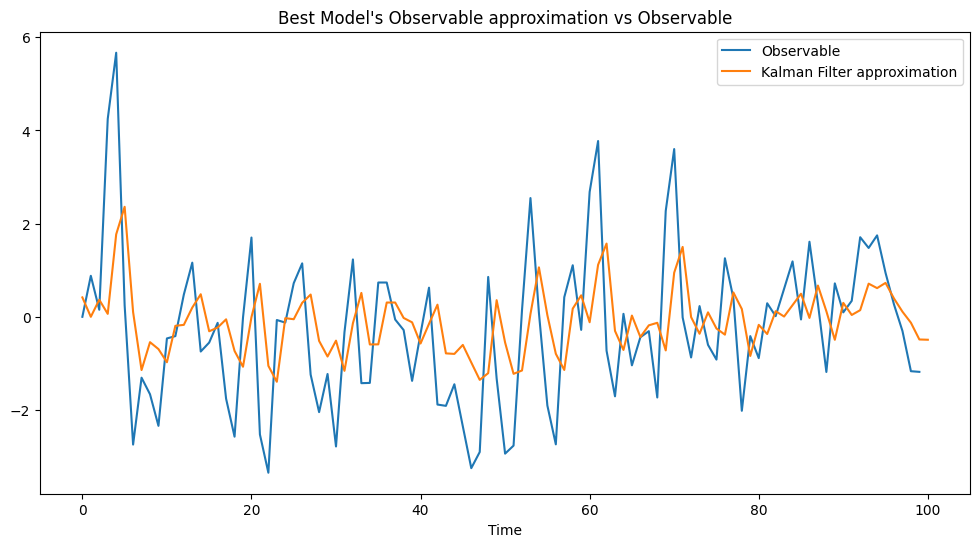

In [44]:
fig, ax = plt.subplots(figsize = (12,6))

Best_Model = KalmanEstimation(Z=np.array([[1]]), Ti= np.array([[i]]) , Q=np.array([[j]]), H=np.array([[0]]), P_0=np.array([[0.1]]), α_0=1, obs=Observations)

ax.plot(Best_Model.obs, label= 'Observable')
ax.plot(Best_Model.Ti * Model.α_t, label = 'Kalman Filter approximation')
ax.set_xlabel('Time')
ax.legend()
ax.set_title("Best Model's Observable approximation vs Observable")

plt.show()